In [1]:
import numpy as np
import pywt
import os
import cv2
from PIL import Image
from scipy.fftpack import dct
from scipy.fftpack import idct
from matplotlib import pyplot as plt
from pywt._doc_utils import wavedec2_keys, draw_2d_wp_basis

In [2]:
image = 'mountain.jpg'   
watermark = 'watermark.jpeg' 

In [3]:
def image_resize(image_name, size):
    img = Image.open(image_name).resize((size, size), 1)
    img_gray = img.convert('L')
    img_rgb = img.convert('RGB')
    image_name2 = 'rgb_'+str(image_name)
    img_gray.save('./dataset/' + image_name)
    img_rgb.save('./dataset/' + image_name2)

 
    image_array = np.array(img_gray.getdata(), dtype=np.float).reshape((size, size))
    image_array_rgb = np.array(img_rgb.getdata(), dtype=np.float).reshape((size, size,3))    

    return img, image_array, image_array_rgb

In [4]:
def mul_wavelet_dec(imArray):
    shape = imArray.shape
    fig, axes = plt.subplots(2, 4, figsize=[14, 8])
    max_lev = 3       # how many levels of decomposition to draw
    label_levels = 3  # how many levels to explicitly label on the plots
    for level in range(0, max_lev + 1):
        if level == 0:
            # show the original image before decomposition
            axes[0, 0].set_axis_off()
            axes[1, 0].imshow(imArray, cmap=plt.cm.gray)
            axes[1, 0].set_title('Image')
            axes[1, 0].set_axis_off()
            continue

        # plot subband boundaries of a standard DWT basis
        draw_2d_wp_basis(shape, wavedec2_keys(level), ax=axes[0, level],
                         label_levels=label_levels)
        axes[0, level].set_title('{} level\ndecomposition'.format(level))

        # compute the 2D DWT
        c = pywt.wavedec2(imArray, 'haar', mode='periodization', level=level)
        # normalize each coefficient array independently for better visibility
        c[0] /= np.abs(c[0]).max()
        for detail_level in range(level):
            c[detail_level + 1] = [d/np.abs(d).max() for d in c[detail_level + 1]]
        # show the normalized coefficients
        arr, slices = pywt.coeffs_to_array(c)
        axes[1, level].imshow(arr, cmap=plt.cm.gray)
        axes[1, level].set_title('Coefficients\n({} level)'.format(level))
        axes[1, level].set_axis_off()

In [5]:
def process_coefficients(imArray, model, level):
    
    coeffs=pywt.wavedec2(data = imArray, wavelet = model, level = level)
    coeffs_H=list(coeffs) 
   
    return coeffs_H

In [6]:
def apply_dct(image_array):
    size = image_array[0].__len__()
    all_subdct = np.empty((size, size))
    for i in range (0, size, 8):
        for j in range (0, size, 8):
            subpixels = image_array[i:i+8, j:j+8]
            subdct = dct(dct(subpixels.T, norm="ortho").T, norm="ortho")
            all_subdct[i:i+8, j:j+8] = subdct

    return all_subdct


In [7]:
def inverse_dct(all_subdct):
    size = all_subdct[0].__len__()
    all_subidct = np.empty((size, size))
    for i in range (0, size, 8):
        for j in range (0, size, 8):
            subidct = idct(idct(all_subdct[i:i+8, j:j+8].T, norm="ortho").T, norm="ortho")
            all_subidct[i:i+8, j:j+8] = subidct

    return all_subidct

In [8]:
def embed_watermark(watermark_array, orig_image):
    orig_image_dummy = orig_image
    watermark_array_size = watermark_array[0].__len__()
    watermark_flat = watermark_array.ravel()
    ind = 0
    
    for x in range (0, orig_image.__len__(), 8):
        for y in range (0, orig_image.__len__(), 8):
            if ind < watermark_flat.__len__():
                subdct = orig_image[x:x+8, y:y+8]
                subdct[5][5] = watermark_flat[ind]
                orig_image_dummy[x:x+8, y:y+8] = subdct
                ind += 1 


    return orig_image_dummy

In [9]:
def print_image_from_array(image_array, name):
  
    image_array_copy = image_array.clip(0, 255)
    image_array_copy = image_array_copy.astype("uint8")
    img = Image.fromarray(image_array_copy)
    img.save('./result/' + name)
    return img

In [10]:
def get_watermark(dct_watermarked_coeff, watermark_size):
    
    subwatermarks = []

    for x in range (0, dct_watermarked_coeff.__len__(), 8):
        for y in range (0, dct_watermarked_coeff.__len__(), 8):
            coeff_slice = dct_watermarked_coeff[x:x+8, y:y+8]
            subwatermarks.append(coeff_slice[5][5])
            
    watermark = np.array(subwatermarks).reshape(watermark_size, watermark_size)*255

    return watermark

def recover_watermark(image_array, model, level, wm_size):


    coeffs_watermarked_image = process_coefficients(image_array, model, level=level)
    coeffs_watermarked_image_l2 = process_coefficients(coeffs_watermarked_image[1][0], model, level=level)
    dct_watermarked_coeff = apply_dct(coeffs_watermarked_image_l2[0])
    
    watermark_array = get_watermark(dct_watermarked_coeff, wm_size)

    watermark_array =  np.uint8(watermark_array)

    #Save result
    img = Image.fromarray(watermark_array)
    img.save('./result/recovered_watermark.bmp')

# Blind Watermarking
In this scenario which is the combination between the wavelet transform and discreate cosine transform. At first, we do the level 2 wavelet tranform for the image and choose the aa component to apply DCT. After we have DCT image, we embedded the watermark image to this domain. Then we get the watermarked image. 

The image below is the example of the wavelet transform with level 1, 2 and 3 decomposition. The result from pywt.wavedec2 is the array of the image which separate in each section. Example, assume we have 2D coeffcient c from a level 2 transfrom, so we get 

In [11]:
model = 'haar'
level = 1
wm_size = 64
ori_img, image_array, image_array_rgb = image_resize(image, 2048)

#mul_wavelet_dec(image_array)
#plt.imshow(image_array)

In [12]:
coeffs_image = process_coefficients(image_array_rgb[:,:,2], model, level=level)
coeffs_image_l2 = process_coefficients(coeffs_image[1][0], model, level=level)

Now we apply the DCT with the coeffs_image[0] which is the aa component in the above image. 

In [13]:
before_wm = apply_dct(coeffs_image_l2[0])
#fig, axes = plt.subplots(1, 1, figsize=[10, 8])
#axes.imshow(dct_arraysinfo)
#axes.set_title("Original DCT from 2nd Coeff Wavelet Transform")
#axes.set_axis_off()

In [15]:
ori_wm, watermark_array, watermark_rgb = image_resize(watermark, wm_size)
watermark_array = watermark_array/255
after_wm = embed_watermark(watermark_array, before_wm)
#fig, axes = plt.subplots(1, 1, figsize=[10, 8])
#axes.imshow(dct_array2[0:0+16, 0:0+16])
#axes.set_title("Wavelet and DCT with Watermark")
#axes.set_axis_off()

In [16]:
coeffs_image_l2_temp = coeffs_image_l2
coeffs_image_l2_temp[0][:][:] = inverse_dct(after_wm)
temp = pywt.waverec2(coeffs_image_l2_temp, model)
coeffs_image_l1_temp = coeffs_image
coeffs_image_l1_temp[1][0][:][:] = temp

In [18]:
image_array_H=pywt.waverec2(coeffs_image_l1_temp, model)

In [19]:
#rgb formulate 
image_wm_array_rgb = np.zeros((2048,2048,3))
image_wm_array_rgb[:,:,2] = image_array_H
image_wm_array_rgb[:,:,0] = image_array_rgb[:,:,0]
image_wm_array_rgb[:,:,1] = image_array_rgb[:,:,1]

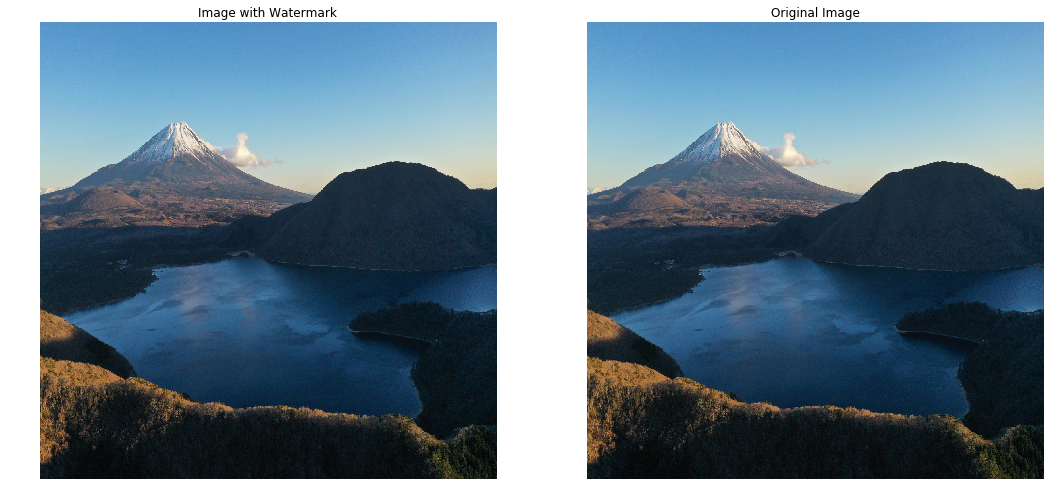

In [20]:
img_with_wm = print_image_from_array(image_wm_array_rgb, 'image_with_watermark.png')
fig, axes = plt.subplots(1, 2, figsize=[18, 10])
axes[0].imshow(ori_img)
axes[0].set_title("Image with Watermark")
axes[0].set_axis_off()

axes[1].imshow(img_with_wm)
axes[1].set_title("Original Image")
axes[1].set_axis_off()

In [21]:
recover_watermark(image_array = image_array_H, model=model, level = level, wm_size=wm_size)

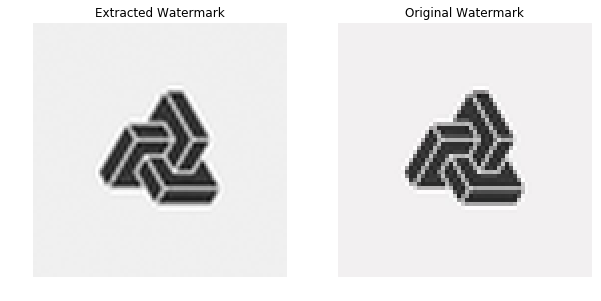

In [25]:
#recover_watermark(image_array = image_array_H, model=model, level = level,wm_size=wm_size)
extracted_wm = Image.open('./result/recovered_watermark.bmp').resize((128, 128), 1)
extracted_wm = extracted_wm.convert('RGB')
fig, axes = plt.subplots(1, 2, figsize=[10, 5])
axes[0].imshow(extracted_wm)
axes[0].set_title("Extracted Watermark")
axes[0].set_axis_off()

axes[1].imshow(ori_wm)
axes[1].set_title("Original Watermark")
axes[1].set_axis_off()

In [24]:
import math
def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))   

d = psnr(image_array_rgb,image_wm_array_rgb)
print(d)

70.25486015354463
